# Deep Q-Learning (DQN) on CartPole

This notebook provides a complete implementation of a **Deep Q-Network (DQN)** agent designed to master the **CartPole-v1** environment. It marks a significant transition from tabular Reinforcement Learning (like the Q-Table) to deep learning-based approaches, enabling the agent to solve problems with continuous observation spaces.

---

## 🧠 1. Deep Q-Learning Theory
Deep Q-Learning replaces the traditional Q-Table with a **Neural Network**. In the CartPole task, the state is represented by four continuous variables (position, velocity, angle, angular velocity). Since these values are infinite, a table cannot store them; instead, the neural network learns to approximate the Q-values for any given state.

* **Objective**: Minimize the difference (loss) between the predicted Q-value and the target Q-value derived from the **Bellman Equation**.
* **Target Calculation**: The target is calculated as the immediate reward plus the discounted maximum future reward predicted by the network for the next state.

---

## 🏗️ 2. Deep Q-Network (DQN) Architecture
The agent uses a multi-layer perceptron (MLP) built with **PyTorch** to map environment observations to actions.

* **Input Layer**: 4 neurons (matching the CartPole observation vector).
* **Hidden Layers**: Three dense layers (256, 128, and 64 neurons) with **ReLU** activation functions to capture complex non-linear relationships.
* **Output Layer**: 2 neurons representing the predicted Q-values for the "Left" and "Right" actions.
* **Optimization**: Uses the **Adam** optimizer and **Mean Squared Error (MSE)** loss function to update the network weights.

---

## 🔄 3. Key Training Mechanisms
To ensure stable and efficient learning, the notebook implements several core DQN strategies:

* **Experience Replay**: The agent maintains a `deque` memory (buffer). Instead of learning from steps in chronological order, it saves transitions and samples a random "mini-batch" for training. This prevents the agent from over-learning a single sequence of events.
* **Epsilon-Greedy Exploration**:
    * **High Epsilon**: Initially, the agent acts randomly to explore the physics of the cart and pole.
    * **Decay**: Over time, `epsilon` is multiplied by a decay factor (0.995), making the agent rely more on its neural network's predictions.
* **Transition Storage**: Every experience is stored as a `namedtuple` containing the state, action, reward, next state, and a boolean flag indicating if the episode ended.

---

## 🚀 4. The Training Process
The training loop runs for a defined number of episodes (e.g., 200) following this lifecycle:

1.  **Observation**: The agent receives the 4D state from the Gymnasium environment.
2.  **Action Selection**: The agent decides to push the cart left or right based on its current exploration/exploitation balance.
3.  **Environment Step**: The cart moves, and the agent receives a reward of +1.0 for every frame the pole stays upright.
4.  **Memory Storage**: The interaction is saved to the replay buffer.
5.  **Replay and Learning**: Once enough transitions are stored, the agent performs a training step on a random batch to refine its neural network.
6.  **Episode Termination**: The episode ends if the pole tilts too far or the cart moves out of bounds.

---

## 📈 5. Evaluation and Results
The notebook tracks the "Total Reward" (number of frames balanced) per episode.

* **Early Episodes**: The agent survives for only 10–20 frames as it learns the basic correlations between actions and pole movement.
* **Learning Curve**: You will observe the rewards gradually climbing as the network stabilizes.
* **Mastery**: A successful agent eventually hits the "perfect score" (typically 500 frames), maintaining the pole in a steady vertical position indefinitely.

In [1]:
from collections import namedtuple, deque
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn

In [2]:
np.random.seed(28)
torch.manual_seed(28)

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))
class DQAgent:
    def __init__(self, env,
                 discount_factor= 0.95,
                 epsilon_greedy= 1.0,
                 epsilon_min= 0.01,
                 epsilon_decay= 0.995,
                 learning_rate= 1e-3,
                 max_memory_size= 2000):
        self.env = env
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n
        self.memory = deque(maxlen= max_memory_size)
        self.gamma = discount_factor
        self.epsilon = epsilon_greedy
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.lr = learning_rate
        self._build_nn_model()

    def _build_nn_model(self):
        self.model = nn.Sequential(
            nn.Linear(self.state_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, self.action_size)
        )
        self.loss_fn = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), self.lr)

    def remember(self, transition):
        self.memory.append(transition)

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        with torch.no_grad():
            q_values = self.model(torch.tensor(state, dtype= torch.float32))[0]
            return torch.argmax(q_values).item()

    def _learn(self, batch_samples):
        batch_targets, batch_states = [], []
        for transition in batch_samples:
            s, a, r, next_s, done = transition
            with torch.no_grad():
                if done:
                    target = r
                else:
                    pred = self.model(torch.tensor(next_s, dtype= torch.float32))[0]
                    target = r + self.gamma * pred.max()
            target_all = self.model(torch.tensor(s, dtype= torch.float32))[0]
            target_all[a] = target
            batch_states.append(s.flatten())
            batch_targets.append(target_all)

        self._adjust_epsilon()
        self.optimizer.zero_grad()
        pred = self.model(torch.tensor(np.array(batch_states), dtype= torch.float32))
        loss = self.loss_fn(pred, torch.stack(batch_targets))
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def _adjust_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def replay(self, batch_size):
        samples = random.sample(self.memory, batch_size)
        return self._learn(samples)

In [3]:
def plot_learning_history(history):
    fig = plt.figure(1, figsize= (15, 5))
    ax = fig.add_subplot(1, 1, 1)
    episodes = np.arange(len(history)) + 1
    plt.plot(episodes, history, lw= 4, marker= 'o', markersize= 10)
    ax.tick_params(axis= 'both', which= 'major', labelsize= 15)
    plt.xlabel('Episodes', size= 20)
    plt.ylabel('Total Rewards', size= 20)
    plt.savefig('deep-q-learning-cartpole.png', dpi= 300)
    plt.show()

In [4]:
EPISODES = 200
batch_size = 32
init_replay_memory_size = 500

C:\Users\98922\ai-env\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Episode: 0/200, Total Reward: 18
Episode: 1/200, Total Reward: 14
Episode: 2/200, Total Reward: 10
Episode: 3/200, Total Reward: 13
Episode: 4/200, Total Reward: 12
Episode: 5/200, Total Reward: 16
Episode: 6/200, Total Reward: 21
Episode: 7/200, Total Reward: 8
Episode: 8/200, Total Reward: 12
Episode: 9/200, Total Reward: 18
Episode: 10/200, Total Reward: 7
Episode: 11/200, Total Reward: 13
Episode: 12/200, Total Reward: 91
Episode: 13/200, Total Reward: 42
Episode: 14/200, Total Reward: 86
Episode: 15/200, Total Reward: 58
Episode: 16/200, Total Reward: 53
Episode: 17/200, Total Reward: 183
Episode: 18/200, Total Reward: 173
Episode: 19/200, Total Reward: 114
Episode: 20/200, Total Reward: 201
Episode: 21/200, Total Reward: 202
Episode: 22/200, Total Reward: 195
Episode: 23/200, Total Reward: 208
Episode: 24/200, Total Reward: 255
Episode: 25/200, Total Reward: 211
Episode: 26/200, Total Reward: 256
Episode: 27/200, Total Reward: 204
Episode: 28/200, Total Reward: 380
Episode: 29/20

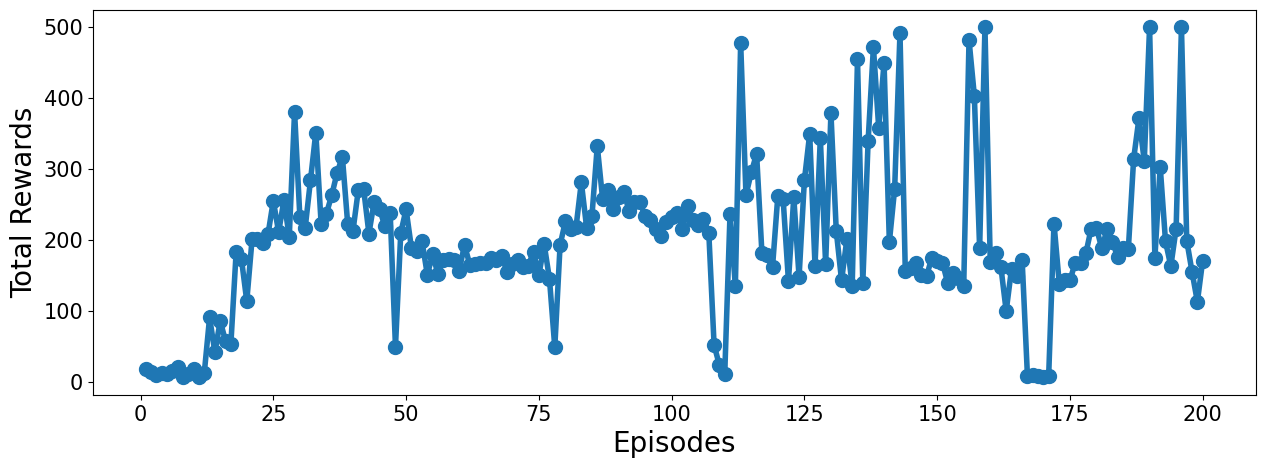

In [5]:
if __name__ == '__main__':
    env = gym.make('CartPole-v1', render_mode= 'human')
    agent = DQAgent(env)
    state, _ = env.reset()
    state = np.reshape(state, [1, agent.state_size])

    for i in range(init_replay_memory_size):
        action = agent.choose_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_state = np.reshape(next_state, [1, agent.state_size])
        agent.remember(Transition(state, action, reward, next_state, done))

        if done:
            state, _ = env.reset()
            state = np.reshape(state, [1, agent.state_size])
        else:
            state = next_state

    total_rewards, losses = [], []
    for e in range(EPISODES):
        state, _ = env.reset()
        state = np.reshape(state, [1, agent.state_size])

        for i in range(500):
            action = agent.choose_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = np.reshape(next_state, [1, agent.state_size])
            agent.remember(Transition(state, action, reward, next_state, done))
            state = next_state
            if done:
                total_rewards.append(i)
                print(f"Episode: {e}/{EPISODES}, Total Reward: {i}")
                break

            if len(agent.memory) >= batch_size:
                loss = agent.replay(batch_size)
                losses.append(loss)

    plot_learning_history(total_rewards)